In [ ]:
# Install Python System Packages (Only Needed Once)

!pip install --upgrade ccxt pandas_ta

In [1]:
# Import Python Libraries 

import ccxt
from datetime import datetime, timedelta, timezone
import math
import argparse
import pandas as pd
import requests
import json
import csv
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)


In [ ]:
# How to Use TA Lib and a List of All Indicators

# Help about this, 'ta', extension
help(df.ta)

# List of all indicators
df.ta.indicators()

# Help about an indicator such as bbands
help(ta.bbands)

In [2]:
# Variables

MARKET="KDA/USDT"
PERIOD="5m" # '1m', 1h
EXCHGE="bittrex"
profit_percent = float(0.025)
loss_percent = float(0.025)
max_count=24
rsi_min=float(40)

In [3]:
# Get Data from Exchange

try:
    exchange = getattr (ccxt, EXCHGE) ()
except AttributeError:
    print('-'*36,' ERROR ','-'*35)
    print('Exchange "{}" not found. Please check the exchange is supported.'.format(EXCHGE))
    print('-'*80)
    quit()
 
# Check if fetching of OHLC Data is supported
if exchange.has["fetchOHLCV"] != True:
    print('-'*36,' ERROR ','-'*35)
    print('{} does not support fetching OHLC data. Please use another exchange'.format(EXCHGE))
    print('-'*80)
    quit()
 
# Check requested timeframe is available. If not return a helpful error.
if (not hasattr(exchange, 'timeframes')) or (PERIOD not in exchange.timeframes):
    print('-'*36,' ERROR ','-'*35)
    print('The requested timeframe ({}) is not available from {}\n'.format(PERIOD,EXCHGE))
    print('Available timeframes are:')
    for key in exchange.timeframes.keys():
        print('  - ' + key)
    print('-'*80)
    quit()
 
# Check if the symbol is available on the Exchange
exchange.load_markets()
if MARKET not in exchange.symbols:
    print('-'*36,' ERROR ','-'*35)
    print('The requested symbol ({}) is not available from {}\n'.format(MARKET, EXCHGE))
    print('Available symbols are:')
    for key in exchange.symbols:
        print('  - ' + key)
    print('-'*80)
    quit()

# Get data
data = exchange.fetch_ohlcv(MARKET, PERIOD)
header = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.DataFrame(data, columns=header)
df.Date = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True) 
df

,Open,High,Low,Close,Volume
Date,,,,,
2022-02-17 04:05:00,7.87823,7.87823,7.87823,7.87823,2.121817
2022-02-17 04:10:00,7.87823,7.87823,7.87823,7.87823,0.000000
2022-02-17 04:15:00,7.87823,7.87823,7.87823,7.87823,0.000000
2022-02-17 04:20:00,7.87823,7.87823,7.87823,7.87823,0.000000
2022-02-17 04:25:00,7.87823,7.87823,7.87823,7.87823,0.000000
...,...,...,...,...,...
2022-02-18 03:40:00,7.17774,7.17774,7.17774,7.17774,0.000000
2022-02-18 03:45:00,7.17774,7.17774,7.17774,7.17774,0.000000
2022-02-18 03:50:00,7.17774,7.17774,7.17774,7.17774,0.000000


In [4]:
# Create Technical Indicators Columns

MACD = ta.macd(close=df['Close'], window_slow = 26, window_fast = 12)
df = pd.concat([df, MACD], axis=1).reindex(df.index)
df['EMA24'] = ta.ema(df['Close'], length=24)
df['SMA24'] = ta.sma(df['Close'], length=24)
df['EMA48'] = ta.ema(df['Close'], length=48)
df['SMA48'] = ta.sma(df['Close'], length=48)
df['EMA200'] = ta.ema(df['Close'], length=200)
df['SMA200'] = ta.sma(df['Close'], length=200)
df['RSI-21'] = ta.rsi(close=df['Close'], length=21)
df['RSI-14'] = ta.rsi(close=df['Close'], length=14)
df['RSI-9'] = ta.rsi(close=df['Close'], length=9)
df['RSI-6'] = ta.rsi(close=df['Close'], length=6)
df['CMO-6'] = ta.cmo(close=df['Close'], length=6, talib = False)
df['CMO-9'] = ta.cmo(close=df['Close'], length=9, talib = False)
df['CMO-14'] = ta.cmo(close=df['Close'], length=14, talib = False)
df['CMO-21'] = ta.cmo(close=df['Close'], length=21, talib = False)
df['ADOSC'] = ta.adosc(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], fastperiod=6, slowperiod=20)
df['KAMA'] = ta.kama(close=df['Close'])
df['BOP'] = ta.bop(open_=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])

df

,Open,High,Low,Close,Volume,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,EMA24,SMA24,...,RSI-14,RSI-9,RSI-6,CMO-6,CMO-9,CMO-14,CMO-21,ADOSC,KAMA,BOP
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-17 04:05:00,7.87823,7.87823,7.87823,7.87823,2.121817,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2022-02-17 04:10:00,7.87823,7.87823,7.87823,7.87823,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2022-02-17 04:15:00,7.87823,7.87823,7.87823,7.87823,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2022-02-17 04:20:00,7.87823,7.87823,7.87823,7.87823,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2022-02-17 04:25:00,7.87823,7.87823,7.87823,7.87823,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18 03:40:00,7.17774,7.17774,7.17774,7.17774,0.000000,0.031367,0.006784,0.024583,7.125913,7.110928,...,64.994364,73.409558,82.830258,NaN,NaN,100.0,33.983887,8.604273,7.177061,1.0
2022-02-18 03:45:00,7.17774,7.17774,7.17774,7.17774,0.000000,0.030918,0.005068,0.025850,7.130059,7.115920,...,64.994364,73.409558,82.830258,NaN,NaN,100.0,33.983887,7.050760,7.177071,1.0
2022-02-18 03:50:00,7.17774,7.17774,7.17774,7.17774,0.000000,0.030214,0.003491,0.026723,7.133874,7.120912,...,64.994364,73.409558,82.830258,NaN,NaN,100.0,7.672776,5.774254,7.177081,1.0


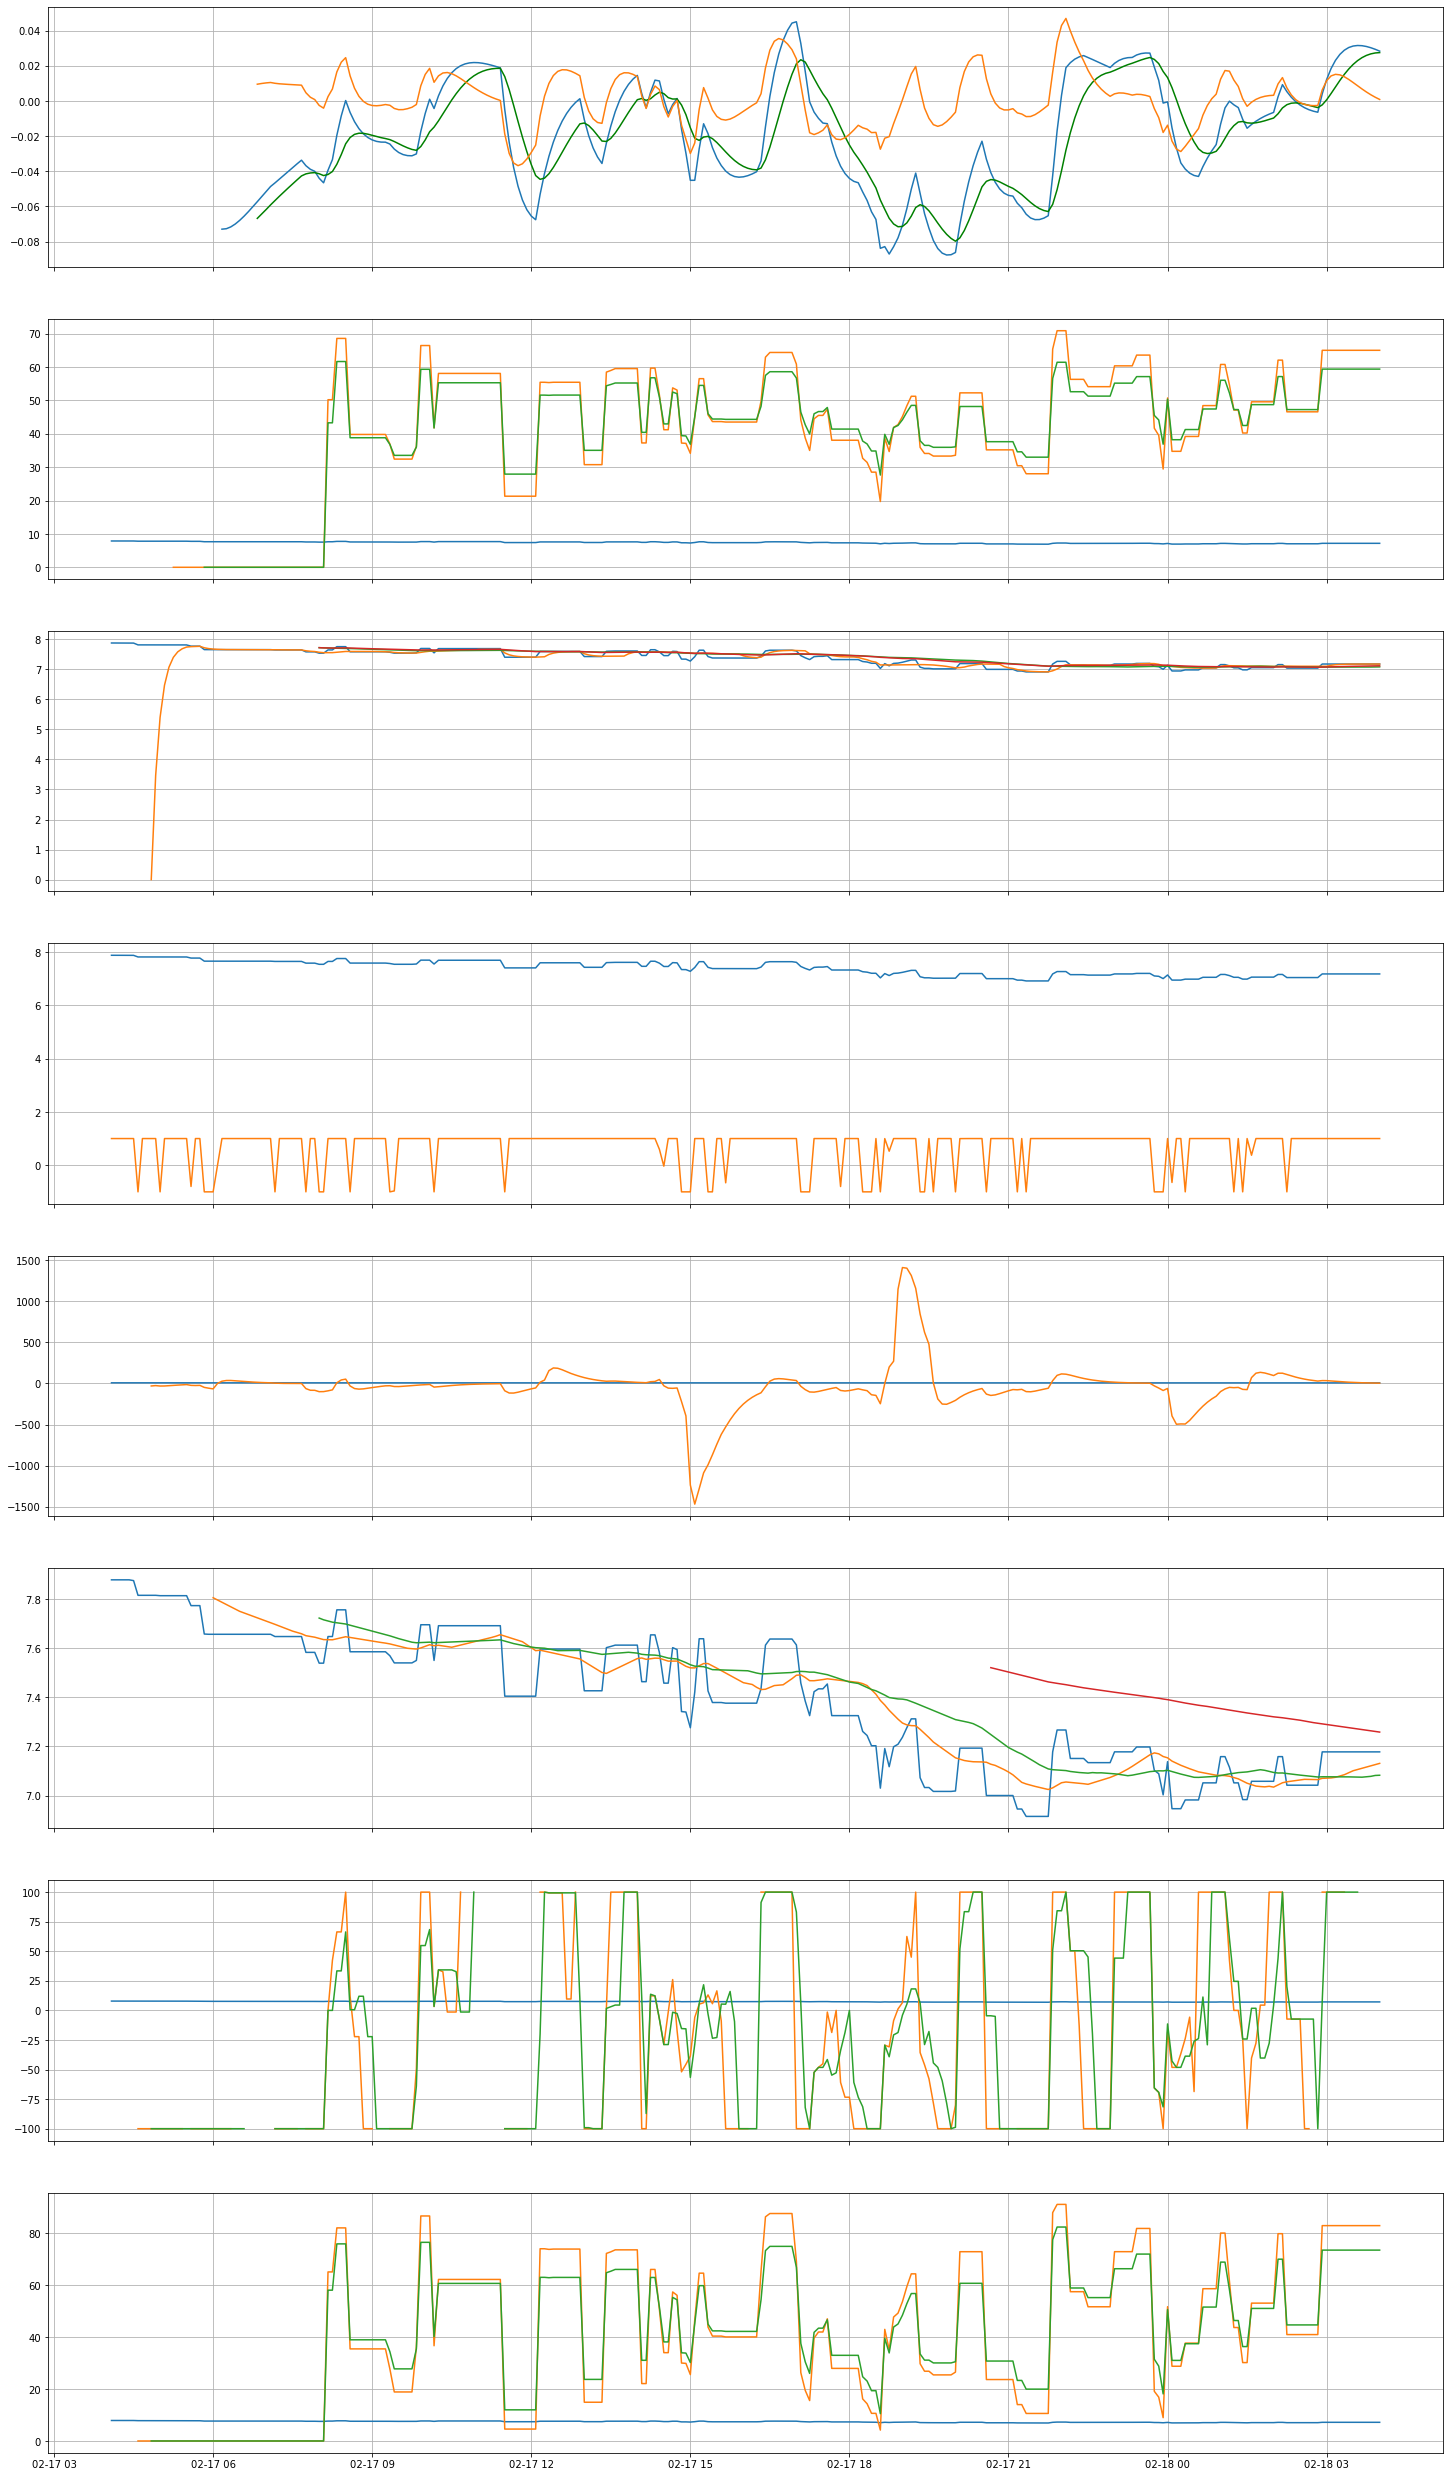

In [6]:
# Plot Market Data and Technical Indicators

plt.style.use('_classic_test_patch')
fig, axs = plt.subplots(8, sharex=True, figsize=(25, 45))
axs[1].plot(df['Close'])
axs[2].plot(df['Close'])
axs[3].plot(df['Close'])
axs[4].plot(df['Close'])
axs[5].plot(df['Close'])
axs[6].plot(df['Close'])
axs[7].plot(df['Close'])
axs[4].plot(df['ADOSC'])
axs[0].plot(df['MACD_12_26_9'])
axs[0].plot(df['MACDs_12_26_9'],'#008000')
axs[0].plot(df['MACDh_12_26_9'])
axs[1].plot(df['RSI-14'])
axs[1].plot(df['RSI-21'])
axs[2].plot(df['KAMA'])
axs[3].plot(df['BOP'])
axs[2].plot(df['SMA48'])
axs[2].plot(df['EMA48'])
axs[6].plot(df['CMO-6'])
axs[6].plot(df['CMO-9'])
axs[7].plot(df['RSI-6'])
axs[7].plot(df['RSI-9'])
axs[5].plot(df['SMA24'])
axs[5].plot(df['SMA48'])
axs[5].plot(df['SMA200'])
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()
axs[5].grid()
axs[6].grid()
axs[7].grid()

Trade Opened @ 7.69611
Trade Open Too Long
Buy: 7.69611 Sell: 7.69144 Trade P/L: -0.004669999999999952
Trade Opened @ 7.42927
Optimal Sale
Buy: 7.42927 Sell: 7.5963 Trade P/L: 0.16703000000000046
Trade Opened @ 7.60702
Optimal Sale
Buy: 7.60702 Sell: 7.51109 Trade P/L: -0.09593000000000007
Trade Opened @ 7.48459
Optimal Sale
Buy: 7.48459 Sell: 7.63724 Trade P/L: 0.1526500000000004
Trade Opened @ 7.24038
Loss Management
Buy: 7.24038 Sell: 7.03264 Trade P/L: -0.20774000000000026
Trade Opened @ 7.19296
Loss Management
Buy: 7.19296 Sell: 7.0 Trade P/L: -0.19296000000000024
Trade Opened @ 7.17774
Optimal Sale
Buy: 7.17774 Sell: 7.17787 Trade P/L: 0.00013000000000040757
Trade Opened @ 7.05157
Optimal Sale
Buy: 7.05157 Sell: 7.05794 Trade P/L: 0.006370000000000431


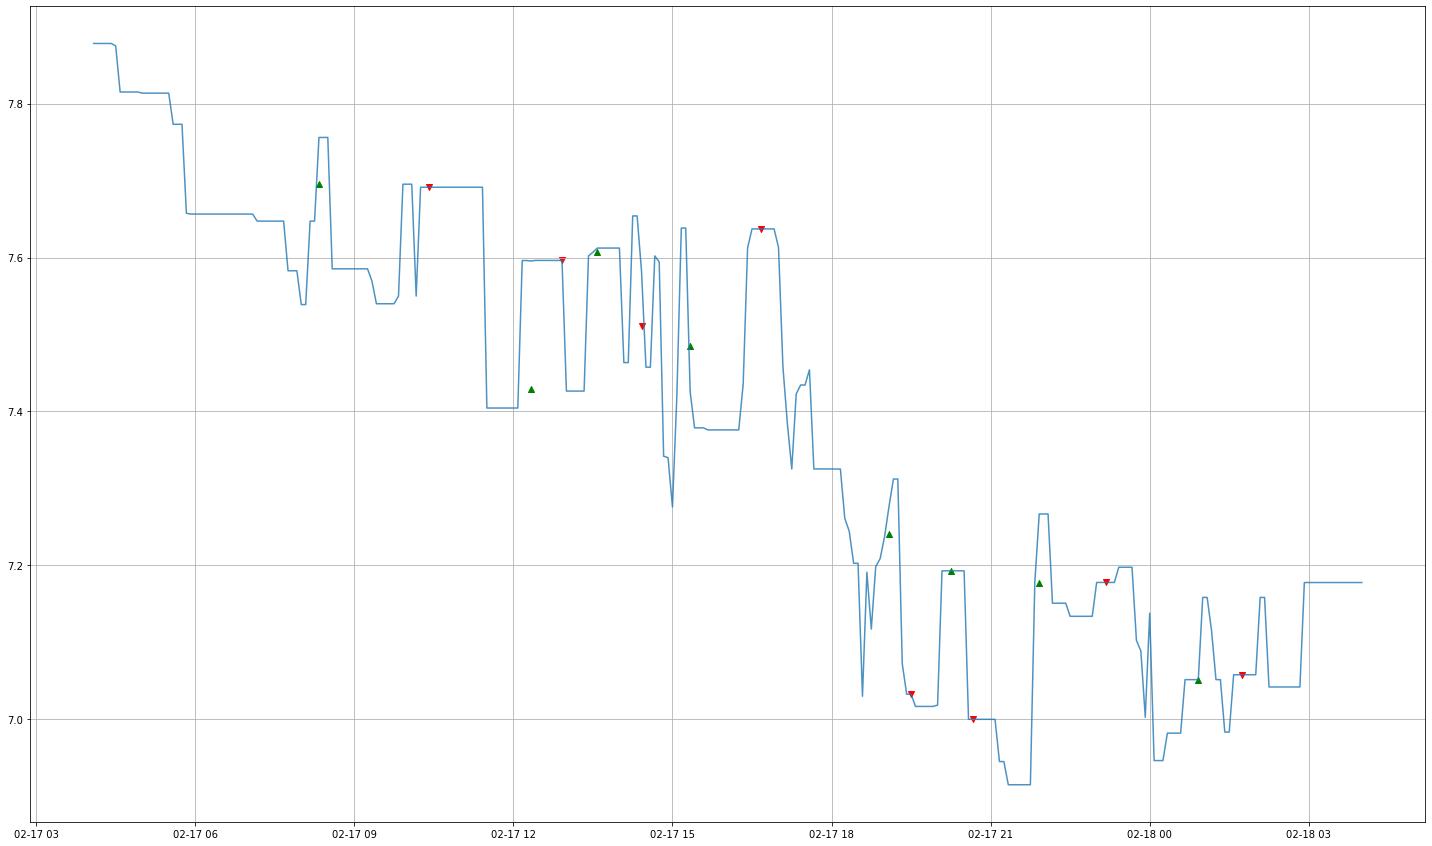

In [24]:
## Calculate the buy & sell signals & Well As Trades

## Initialize the columns that we need
df['Buy Signal'] = np.nan
df['Sell Signal'] = np.nan
df['Buy Price'] = np.nan
df['Sell Price'] = np.nan
df['Trade Value'] = np.nan
 
def check_rsi(df, x, rsi_label, low):
    check = False
    if float(df[rsi_label][x]) < low:
        if float(df[rsi_label][x]) > float(df[rsi_label][x-1]):
            check = True
    return check       
        

## Calculate the buy & sell signals
open_trade=False
buy=0
count=0

for x in range(24, len(df)):
#    print(str(check_rsi(df,x,'RSI-9', rsi_min)))
    if open_trade and df['Buy Signal'][x-1] == True:
        df['Buy Price'][x] = df['Open'][x]
        buy = float(df['Open'][x])
        count=0
        profit_target = (float(1.0) + profit_percent) * float(buy)
        loss_target = (float(1.0) - loss_percent) * float(buy)
        print("Trade Opened @ "+str(buy))
    elif (open_trade != True) and df['Sell Signal'][x-1] == True:
        df['Sell Price'][x] = df['Open'][x]
        df['Trade Value'][x] = float(df['Open'][x]) - buy
        print("Buy: "+str(buy)+" Sell: "+str(df['Sell Price'][x])+ " Trade P/L: "+str(df['Trade Value'][x]))
    elif (open_trade != True) and float(df['KAMA'][x]) >= float(df['KAMA'][x-2]) and float(df['KAMA'][x]) < float(df['Close'][x]) and ( float(df['RSI-14'][x-1]) < rsi_min or float(df['RSI-14'][x-2]) < rsi_min or float(df['RSI-14'][x-3]) < rsi_min or float(df['RSI-14'][x-4]) < rsi_min) and float(df['MACDh_12_26_9'][x]) > 0:
        df['Buy Signal'][x] = True
        open_trade=True
        count=0
    # Profit Take    
    elif (open_trade == True) and (df['Close'][x] >= profit_target) and count > 0:
        df['Sell Signal'][x] = True
        open_trade=False
        print("Profit Take")
    elif (open_trade == True) and (df['Close'][x] <= loss_target) and count > 0:
        df['Sell Signal'][x] = True
        open_trade=False
        print("Loss Management")
    elif (open_trade == True) and (count >= max_count) and count > 0:
        df['Sell Signal'][x] = True
        open_trade=False
        print("Trade Open Too Long")
    elif (open_trade == True) and float(df['Close'][x]) <= float(df['Close'][x-1]) and buy < float(df['Close'][x]) and count > 5:
        df['Sell Signal'][x] = True
        open_trade=False
        print("Optimal Sale")
    count = count + 1
        

## Chart the buy/sell signals:
plt.style.use('_classic_test_patch')
fig, ax = plt.subplots(sharex=True, figsize=(25,15))
## Chart the stock close price & buy/sell signals:
ax.scatter(df.index, df['Buy Price'],  color = 'green',  marker = '^', alpha = 1)
ax.scatter(df.index, df['Sell Price'],  color = 'red',  marker = 'v', alpha = 1)
ax.plot(df['Close'], alpha = 0.8)
ax.grid()


In [19]:
for x in df.iloc[24:].iterrows():
    print(x)

(Timestamp('2022-02-17 06:05:00'), Open             7.656540e+00
High             7.656540e+00
Low              7.656530e+00
Close            7.656540e+00
Volume           2.000000e+02
MACD_12_26_9              NaN
MACDh_12_26_9             NaN
MACDs_12_26_9             NaN
EMA24            7.793434e+00
SMA24            7.796100e+00
EMA48                     NaN
SMA48                     NaN
EMA200                    NaN
SMA200                    NaN
RSI-21           0.000000e+00
RSI-14           0.000000e+00
RSI-9            0.000000e+00
RSI-6            0.000000e+00
CMO-6           -1.000000e+02
CMO-9           -1.000000e+02
CMO-14          -1.000000e+02
CMO-21          -1.000000e+02
ADOSC            5.235946e-01
KAMA             7.667236e+00
BOP              2.220446e-11
Buy Signal                NaN
Sell Signal               NaN
Buy Price                 NaN
Sell Price                NaN
Trade Value               NaN
Name: 2022-02-17 06:05:00, dtype: float64)
(Timestamp('2022-02-17